# Generating NDVI animations

* **Products used:** 
[ndvi_anomaly](https://explorer.digitalearth.africa/ndvi_anomaly)

## Background
This notebook shows how to generate an animation to visualise the NDVI across space, mean NDVI through time, and NDVI anomalies. It also generates a similar animation for monthly rainfall and rainfall anomalies.

Animations can help visualise changes in patterns through time. The visualisation of both mean values and anomalies means that seasonal and inter-annual aspects of time can be assessed. Complementing this with spatial images enhances interpretability of earth observation data.

## Description

The workflow for generating an animation progresses through the following steps:
1. Select an area of interest.
2. Load DE Africa Mean NDVI and Anomalies product.
3. Mask to cropland.
4. Generate NDVI animation.
5. Generate rainfall animation.
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages and apps" cell.

### Load packages

In [1]:
%matplotlib inline

import datacube
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.dates as mdates
from deafrica_tools.plotting import display_map

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


Connect to the datacube.

In [2]:
dc = datacube.Datacube(app='NDVI-animation')

### Analysis parameters

The default area is cropland in Madagascar.

---

In [3]:
# Define the area of interest for the analysis
lat = -17.71
lon = 48.21
buffer = 0.05
year = "2022"

latitude = (lat - buffer, lat + buffer)
longitude = (lon - buffer, lon + buffer)

display_map(longitude, latitude)

We will define the start and end date as the beginning and end of our year of interest.

In [4]:
start_date = dt.datetime.strptime(year, "%Y").replace(month=1, day=1)
end_date = dt.datetime.strptime(year, "%Y").replace(month=12, day=31)

Below, the analysis parameters are used to construct a query which loads the DE Africa mean NDVI and anomalies product.

In [5]:
# Construct the data cube query    
query = {
       'x': longitude,
       'y': latitude,
       'time': (start_date, end_date),
       'output_crs': 'EPSG:6933',
    'resolution': (-30, 30)
    }

ds = dc.load(product="ndvi_anomaly", **query)
ds

<xarray.Dataset>
Dimensions:           (time: 12, y: 406, x: 323)
Coordinates:
  * time              (time) datetime64[ns] 2022-01-16T11:59:59.999999 ... 20...
  * y                 (y) float64 -2.218e+06 -2.218e+06 ... -2.23e+06 -2.231e+06
  * x                 (x) float64 4.647e+06 4.647e+06 ... 4.656e+06 4.656e+06
    spatial_ref       int32 6933
Data variables:
    ndvi_mean         (time, y, x) float32 0.4654 0.4267 0.3652 ... nan nan nan
    ndvi_std_anomaly  (time, y, x) float32 -0.1621 0.2036 0.3302 ... nan nan nan
    clear_count       (time, y, x) int8 4 4 4 4 4 4 4 4 4 ... 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

### Load cropland mask

This is an optional step for masking the NDVI data to cropland. In this instance, we are interested in inspecting crop vegetation patterns only, so we use the mask to do this.

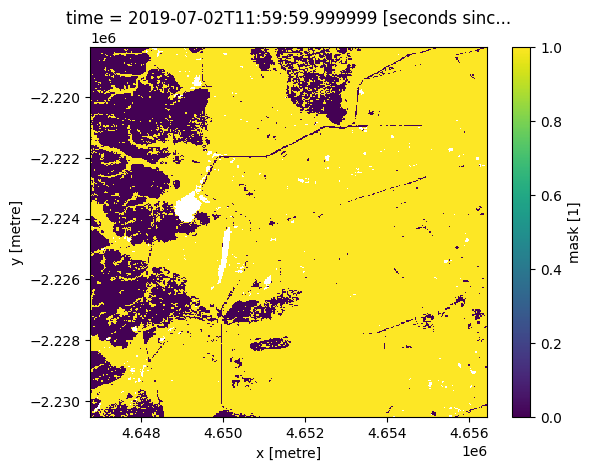

In [6]:
query = {
       'x': longitude,
       'y': latitude,
       'time': '2019',
       'output_crs': 'EPSG:6933',
    'resolution': (-30, 30),
    'measurements': 'mask'
    }

cm = dc.load(product='crop_mask', **query).squeeze()
cm.mask.where(cm.mask<255).plot()

### Mask NDVI to cropland

We mask the NDVI data to the cropland extent shown above.

In [7]:
ds = ds.where(cm.mask ==1)

## Prepare animation data

We need to prepare three objects for the animation:
1. Mean NDVI with spatial attributes.
2. Mean NDVI through time, aggregated as an average across space.
3. NDVI anomalies for each month, aggregated as an average across space.

In [8]:
ds_mean = ds.ndvi_mean

ds_mean_1D = ds_mean.mean(dim=['x', 'y'], skipna=True)

ndvi_anom = ds.ndvi_std_anomaly.mean(dim=['x', 'y']).to_dataframe().drop(['spatial_ref'], axis=1)

## Run animation

To create the animation, the cell below follows a few key steps:
1. Define the layout of the three axes and their size.
2. Set axis parameters (titles etc)
3. Start each axis with the first image of the animation (Januray).
4. Define an update function which adds each month sequentially to each of the three charts.
5. Run the animation.

Note the animation renders in its own window. The bottom right toggle enables download of the animation.

In [9]:
# create a figure and axes
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)


ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=2)

# setup starting plot
cax = ds.ndvi_mean[0,:,:].plot(
    add_colorbar=True,
    cmap='RdYlGn',
    vmin=-1, vmax=1,
    cbar_kwargs={
        'extend':'neither'
    },
    ax=ax2
)

ax1.set_ylim([0, 1])
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_title("Mean NDVI")
ax1.set_xlabel("Date")
ax1.set_ylabel("NDVI")

ax3.set_ylim([-4, 4])
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax3.set_title("NDVI Anomaly")
ax3.set_xlabel("Date")
ax3.set_ylabel("Std Deviations from monthly mean")
ax3.axhline(0, color='black', linestyle='--')
    
x = ds_mean_1D.time
y = ds_mean_1D
                                                                         
x2 = ndvi_anom.index
y2 = [0] * ndvi_anom.ndvi_std_anomaly
bars = ax3.bar(x2, y2, align='center', width=20,color=(ndvi_anom.ndvi_std_anomaly > 0).map({True: 'g', False: 'brown'}))

line, = ax1.plot(x, y, marker='*',
                color='blue')

def update(num, x, y, x2, y2, bars, line):
    y2[num] = ndvi_anom.ndvi_std_anomaly[num]
    bars[num].set_height(y2[num])
    cax.set_array(ds.ndvi_mean[(num),:,:].values.flatten())
    ax2.set_title("Time = " + str(ds.ndvi_mean.coords['time'].values[(num)])[:12])
    line.set_data(x[:num+1], y[:num+1])
    return line,

plt.tight_layout()
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, x2, y2, bars, line],
                              interval=400, blit=False, repeat=True)
#ani.save('ndvi_anim.gif')

plt.close()  

HTML(ani.to_html5_video())

# Make an NDVI animation with rainfall

The animation above summarises cropland NDVI in space and time, within a period of interest. We can add associated information to this visualisation, such as rainfall. The next few steps demonstrate how to load rainfall data and calculate anomalies for plotting.

## Rainfall anomaly parameters

We need to set some parameters for calculating the rainfall anomaly. The `time_m` period is a baseline period while `time_x` is the year of interest.

In [10]:
# Set the range of dates for the climatology, this will be the reference period (m) for the anomaly calculation.
# Standard practice is to use a 30 year period, so we've used 1981 to 2011 in this example.
time_m = ('2000', '2020')

# time period for monthly anomaly (x)
time_x = ('2022')

# CHIRPS has a spatial resolution of ~5x5 km
resolution = (-5000, 5000)

#size of dask chunks
dask_chunks = dict(x=500,y=500)

query_m = {
       'x': longitude,
       'y': latitude,
       'time': time_m,
       'output_crs': 'EPSG:6933',
    'resolution': (-5000, 5000)
    }

query_x = {
       'x': longitude,
       'y': latitude,
       'time': time_x,
       'output_crs': 'EPSG:6933',
    'resolution': (-5000, 5000)
    }

### Load rainfall data

In [11]:
ds_rf_m = dc.load(product='rainfall_chirps_monthly', **query_m)
ds_rf_x = dc.load(product='rainfall_chirps_monthly', **query_x)

Below, we calculate the monthly mean rainfall and anomaly.

In [12]:
# monthly means
climatology_mean = ds_rf_m.groupby('time.month').mean('time').compute()

#calculate monthly std dev
climatology_std = ds_rf_m.groupby('time.month').std('time').compute()

stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    ds_rf_x.groupby("time.month"),
    climatology_mean,
    climatology_std,
    output_dtypes=[ds_rf_x.rainfall.dtype],
    dask="allowed"
).compute()

### Prepare animation data

As for the NDVI animation above, we need to prepare dataframes for the rainfall animation.

In [13]:
spatial_mean_rain = ds_rf_x.rainfall.mean(['x','y'])

spatial_mean_rain.time

spatial_mean_anoms = stand_anomalies.rainfall.mean(['x','y'], skipna=True).sel(time=slice('2021-12-31', end_date)).to_dataframe().drop(
    ['spatial_ref', 'month'], axis=1).fillna(0)

## Run the animation

We follow the steps listed for the NDVI animation above to produce the rainfall animation.

In [14]:
# create a figure and axes
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)


ax1 = plt.subplot2grid(shape=(2, 2), loc=(0, 1), colspan=2)
ax2 = plt.subplot2grid(shape=(2, 2), loc=(0, 0), rowspan=2)
ax3 = plt.subplot2grid(shape=(2, 2), loc=(1, 1), colspan=2)

cax = ds.ndvi_mean[0,:,:].plot(
    add_colorbar=True,
    cmap='RdYlGn',
    vmin=-1, vmax=1,
    cbar_kwargs={
        'extend':'neither'
    },
    ax=ax2
)

ax1.set_title("Monthly Total Rainfall")
ax1.set_xlabel("Date")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax1.set_ylabel("Monthly Rainfall (mm)")

ax3.clear()
ax3.set_ylim([-4, 4])
ax3.xaxis_date()
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
ax3.set_title("Rainfall Anomaly")
ax3.set_xlabel("Date")
ax3.set_ylabel("Std Deviations from monthly mean")
ax3.axhline(0, color='black', linestyle='--')

def update(num, x, y, line):
    y2[num] =  spatial_mean_anoms.rainfall[num]
    bars[num].set_height(y2[num])
    cax.set_array(ds.ndvi_mean[(num),:,:].values.flatten())
    ax2.set_title("Time = " + str(ds.ndvi_mean.coords['time'].values[(num)])[:12])
    line.set_data(x[:num+1], y[:num+1])
    return line,
    
x = spatial_mean_rain.time
y = spatial_mean_rain
                                                                         
x2 = spatial_mean_anoms.index
y2 = [0] * spatial_mean_anoms.rainfall
bars = ax3.bar(x2, y2, align='center', width=20,color=(spatial_mean_anoms.rainfall > 0).map({True: 'b', False: 'r'}))

line, = ax1.plot(x, y, marker='*',
                color='blue')
plt.tight_layout()
ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=400, blit=True)

plt.close()  

HTML(ani.to_html5_video())

## Drawing conclusions

The animations enable us to inspect how vegetation changes within a year, and by showing anomalies, how the year of interest compares to a historical baseline.

This kind of analysis can assist in assessment of crop production in a given year, and can feed into early warning systems and forecasts on crop production and food security.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [15]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [16]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-05-30'